# Homework # 3: Neural Networks
Members: Jack Hanke, Daniel Plotkin, Hanna Zelis, Nicole Birova, & Vrishani Shah

Due: November 19

In [7]:
import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
%matplotlib inline

################################################################################
# Some simple plotting and data reading utilities
################################################################################


def plot_data(data: np.ndarray,
              labels: np.ndarray,
              ax: matplotlib.axes.Axes = None):
    """
    A helper function to plot our data sets

    PARAMETERS
    ----------
    data      A numpy array of 2 columns (dimensions) and 2*examples_per_class rows

    labels    A numpy vector with 2*examples_per_class, with a +1 or -1 in each
              element. The jth element is the label of the jth example

    ax        An optional matplotlib axis object to plot to
    """

    # require shape (n, 2)
    assert data.ndim == 2
    assert data.shape[-1] == 2

    if type(data) == torch.Tensor:
        data = data.numpy()

    # plot the data
    pos_idx = np.where(labels == 1)
    neg_idx = np.where(labels == -1)

    if ax is None:
        ax = plt
    ax.plot(
        data.T[0, pos_idx],
        data.T[1, pos_idx],
        'r^',
        label='positive'
    )
    ax.plot(
        data.T[0, neg_idx],
        data.T[1, neg_idx],
        'bo',
        label='negative'
    )
    ax.axis('equal')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="upper right")

    if ax is None:
        plt.show()


def plot_decision_surface(model=None,
                          axis_limits=(-5, 5, -5, 5),
                          ax: matplotlib.axes.Axes = None
                          ):
    """
    Creates a grid of points, measures what a model would label each
    point as, and uses this data to draw a region for class +1 and a region for
    class -1.

    PARAMETERS
    ----------
    model       A callable model that can take 2-d real-valued input and produce
                a +1 or -1 label for each data point.

    axis_limits An array-like object with 4 floats [lowest_horizontal, highest_horizontal,
                lowest_vertical, highest_vertical]. This sets the limits over which
                the decision surface will be caluclated and plotted.

    ax          An optional matplotlib axis object to plot to

    RETURNS
    -------
    my_contour  a matplotlib.contour.QuadContourSet with the contour
    """

    # Create a grid of points spanning the entire space displayed in the axis.
    # This will let us draw the decision boundary later
    xx, yy = np.meshgrid(np.arange(axis_limits[0], axis_limits[1], .05),
                         np.arange(axis_limits[2], axis_limits[3], .05))
    data = np.concatenate([xx.reshape([1, -1]), yy.reshape([1, -1])]).T
    # changed to added ones to allign with label data
    # temp = np.ones((data.shape[0], 1))
    # data = np.hstack((data, temp))

    # Predict the class of each point in XGrid, using the classifier.
    # This shows our regions determined by the classifier
    if isinstance(model, nn.Module):
        with torch.no_grad():
            pl = model(torch.tensor(data).to(dtype=torch.float32))
            # pl = torch.argmax(pl, dim=1)
            predicted_labels = np.sign(pl.numpy())
    else:
        predicted_labels = model(data)

    predicted_labels = predicted_labels.reshape(xx.shape)

    # Put the result into a color plot
    if ax is None:
        ax = plt

    ax.contourf(xx, yy, predicted_labels, cmap=plt.cm.Paired)
    ax.axis('equal')
    ax.axis('tight')

    if ax is None:
        plt.show()


def compute_bounds(features):
    min1, max1 = features[:, 0].min()-1, features[:, 0].max()+1
    min2, max2 = features[:, 1].min()-1, features[:, 1].max()+1
    return (min1, max1, min2, max2)


def plot_decision_regions(
        features, targets, model,
        axis=None, transform=None,
        bounds=None,
        title='Decision Surface'):
    """
    Slightly different plotting approach than above. Used in backprop demo.

    This function produces a single plot containing a scatter plot of the
    features, targets, and decision region of the model.

    Args:
        features (np.ndarray): 2D array containing real-valued inputs.
        targets (np.ndarray): 1D array containing binary targets.
        model: a learner with .predict() method
        axis: the axis on which to plot. If None, create a new plot
        title: title of the plot
    Returns:
        None (plots to the active figure)
    """

    # define bounds of the domain
    if bounds is None:
        min1, max1, min2, max2 = compute_bounds(features)
    else:
        min1, max1, min2, max2 = bounds

    # define grid for visualizing decision regions
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)

    xx, yy = np.meshgrid(x1grid, x2grid)

    # flatten grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    # horizontally stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))

    # if we're transforming the features, do that now
    #     this allows xx and yy to still be in 2D for the visualization
    #     but grid has been transformed so it matches up with the fit model
    if transform is not None:
        grid = transform(grid)

    # generate predictions over grid
    yhat = model.predict(grid)

    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)


    if axis is None:
        fig, axis = plt.subplots()

    # plot the grid of x, y and z values as a surface
    binary_cmap = matplotlib.colors.ListedColormap(['#9ce8ff', '#ffc773'])
    axis.contourf(xx, yy, zz, cmap=binary_cmap, alpha=0.7)

    # plot "negative" class:
    row_idx_neg = np.where(targets < 0.5)[0]
    axis.scatter(
        features[row_idx_neg, 0], features[row_idx_neg, 1],
        label='negative')

    # plot "positive" class:
    row_idx_pos = np.where(targets > 0.5)[0]
    axis.scatter(
        features[row_idx_pos, 0], features[row_idx_pos, 1],
        label='positive')

    axis.set_title(title)
    axis.set_xlim(min1, max1)
    axis.set_ylim(min2, max2)

    axis.legend(loc="upper left")


def read_data(name, mode):
    x_data = []
    y_data = []
    label_data = []

    base_dir = os.getcwd()
    root = base_dir
    filename = '%s/%s_%s.csv' % (root,name,mode)

    i = 0
    with open(filename,'rt') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = line.split(',')
            if i > 0:
                y = int(float(tokens[0]))
                x1 = float(tokens[1])
                x2 = float(tokens[2])
                x_data.append([1.0,x1,x2])
                y_data.append([y])
                temp = [0,0]
                temp[y] = 1
                label_data.append(temp)
            i = i + 1
    # xs = np.array(x_data,dtype='float32')
    # ys = np.array(y_data,dtype='float32')
    # labels = np.array(label_data,dtype='float32')
    xs = torch.Tensor(x_data)
    ys = torch.Tensor(y_data)
    labels = torch.Tensor(label_data)
    return(xs,ys,labels)

## Question 1. PyTorch Implementation with MCE (2.0 points)

Implement and train a FFNN as specified above using PyTorch and multi-class cross entropy as the cost function. Experiment with each of the four datasets to find the best number of nodes $k$ from $\{2, 3, 5, 7, 9\}$ in the hidden layer. For the best $k$ for *each* dataset:

a. list hyper-parameters used in the model,

b. plot the learning curves for training and validation loss as a function of training epochs,

c. provide the final test accuracy, defined as the number of correct classifications divided by the total number of examples,

d. plot the learned decision surface along with observations from the test set (see example below), and

e. discuss your design choices and comment on how they impact performance

## Responses to Question 1

For sub-question *a*, the number of hidden neurons `k` was tested on $\{2, 3, 5, 7, 9\}$, and `k=9` preformed the best on all datasets.  Additionally, all datasets use a `learning_rate` of `0.01` and a `batch_size` of `5` for training. The `num_epochs` varies based on how quickly performance on the validation stops improving. 

For sub-questions *b*, *c*, and *d*, please view the output of the below code cell. All output for each dataset is properly marked and printed out. 

For sub-question *e*, the `k=9` hidden neurons network was chosen as the best for each dataset. Note that for the `xor` and `two_gaussians` dataset, the learning curves for `k=7` and `k=9` are similar, but eventually the two networks converge to the same minimal cost. 

- For the `xor` dataset, the number of epochs is set to `400`.
- For the `center_surround` dataset, the number of epochs is set to `100`.
- For the `two_gaussians` dataset, the number of epochs is set to `150`.
- For the `spiral` dataset, the number of epochs is set to `600`.


Beginning modelling for the xor dataset...

Training without regularization


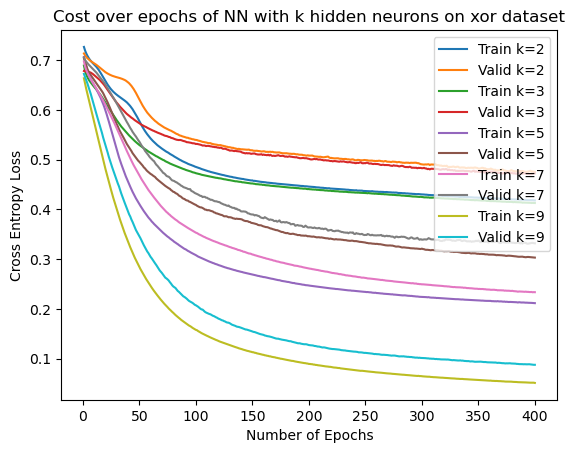

Test accuracy for xor dataset for NN with k=9 is 99.00%.


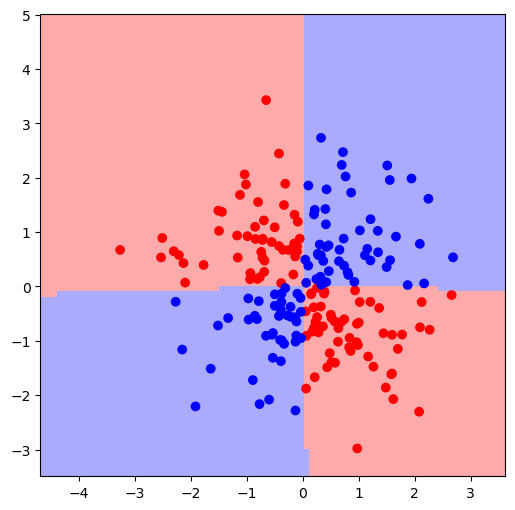


****************************************************************************************************
Beginning modelling for the center_surround dataset...

Training without regularization


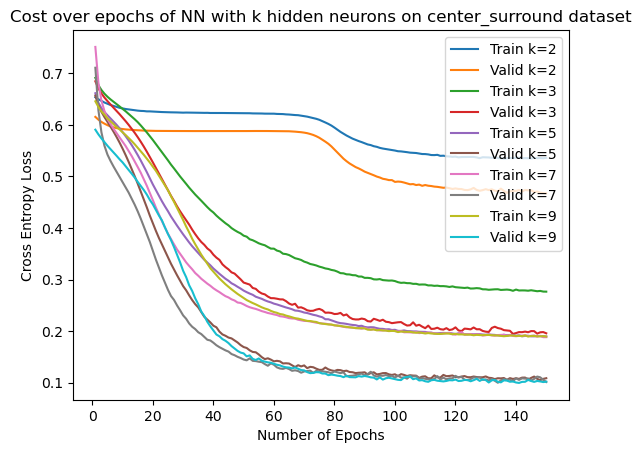

Test accuracy for center_surround dataset for NN with k=9 is 74.50%.


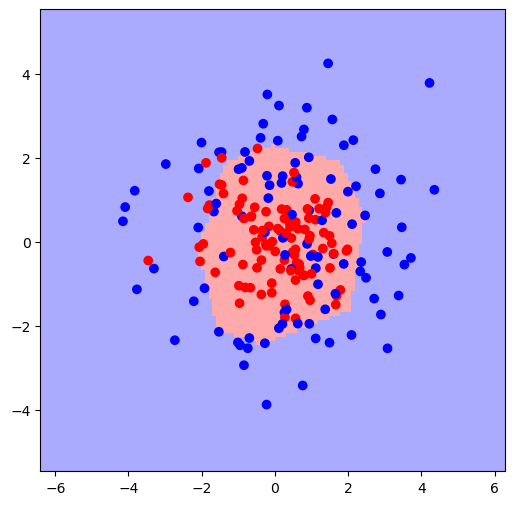


****************************************************************************************************
Beginning modelling for the two_gaussians dataset...

Training without regularization


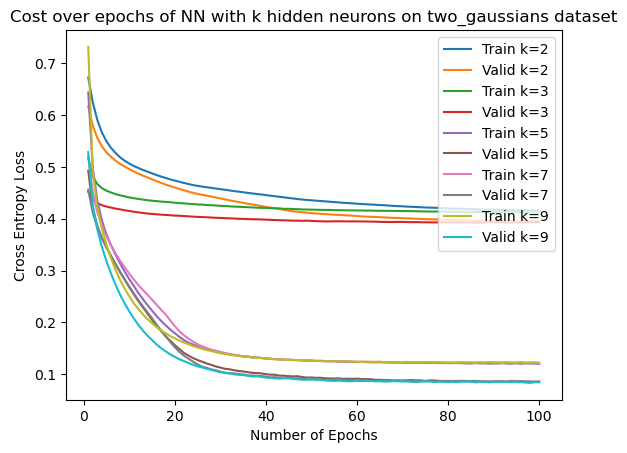

Test accuracy for two_gaussians dataset for NN with k=9 is 91.00%.


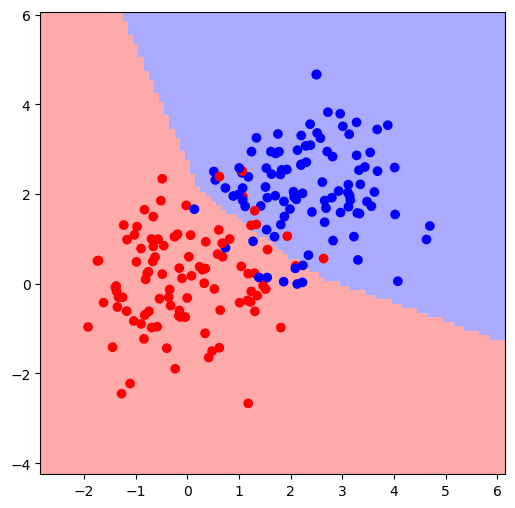


****************************************************************************************************
Beginning modelling for the spiral dataset...

Training without regularization


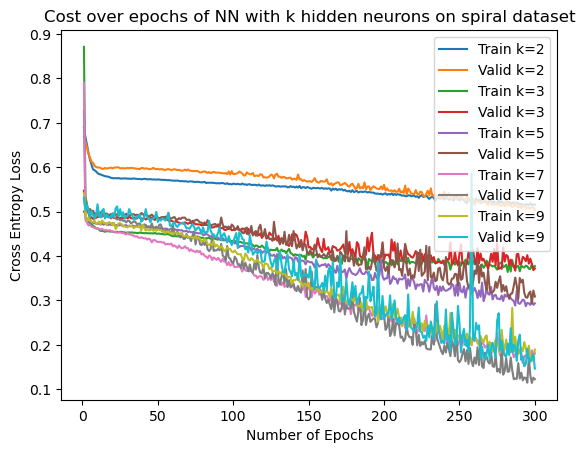

Test accuracy for spiral dataset for NN with k=9 is 99.00%.


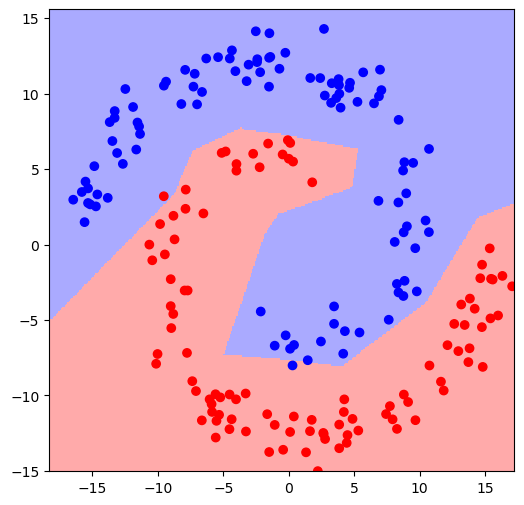


****************************************************************************************************


In [32]:
# Question 1

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from matplotlib.colors import ListedColormap
from typing import Union, Callable, Literal

# set random seed for reproducibility
torch.manual_seed(343)

# define network for Question 1
class Q1_Net(nn.Module):
    def __init__(self,k):
        #initialize parent class nn.Module 
        super(Q1_Net, self).__init__()
        #first linear layer with 3 input features, 'k' output neurons (no bias as it is appended separately)
        self.layer1 = nn.Linear(3, k, bias=False) # bias is appended to all samples from read_data function
        #second linear layer with 'k' input nerons, 2 output nerons (no bias as it is appended separately)
        self.layer2 = nn.Linear(k, 2, bias=False)

    def forward(self, input_vals):
        #convert input values to torch tensor if not already
        input_vals = torch.Tensor(input_vals)
        #first layer activation function with ReLU (rrectified linear unit) function
        activation_1 = F.relu(self.layer1(input_vals)) # chad relu
        #output layer without activation (for compatibility with loss function)
        output = self.layer2(activation_1) 
        return output
    

class CustomDatasetQ1(Dataset):
    '''Custom dataset class to handle data for training and validation'''
    def __init__(self, data: torch.Tensor, labels: torch.Tensor):
        #store data and labels, converting labels to long (integer) type
        self.data = data
        self.labels = labels.squeeze(-1).long() # Squeeze and convert to long

    def __len__(self):
        #return length of dataset
        return len(self.data)
    
    def __getitem__(self, idx):
        #return data and label at index 'idx'
        return self.data[idx], self.labels[idx]
    

class Classifier:
    """Classifier to help us train, validate, and predict with a `nn.Module`."""
    def __init__(self, network: nn.Module, train_loader: DataLoader, valid_loader: DataLoader, loss_fn: Union[nn.CrossEntropyLoss, nn.MSELoss]):
        #initialize neural network model for training
        self.network = network
        #DataLoader for training data
        self.train_loader = train_loader
        #DataLoader for validation data
        self.valid_loader = valid_loader
        #loss function to compute training/validation error
        #Loss function: calculates the error b/w mode's predictions and actual values (helps optimizer adjust params & improv accuracy)
        self.loss_fn = loss_fn
        #optimizer initialization
        #optimizer: updates the model's parameters during training to minimize the loss
        #           applies an optimization algo to adjust weights based on the gradients calculated during backpropagation
        self.optimizer = None

    def train(self, lr: float, num_epochs: int, optimizer_class: type[torch.optim.Optimizer] = torch.optim.SGD, use_regularizer = False, plot_epochs = None, custom_plotter=None, dataset_name=None, **optimizer_kwargs) -> tuple[list[float], list[float]]:
        """Trains network and returns train and validation losses"""
        # Define optimizer with model's parameter, a specified learning rate (lr), and additional keyword arguments for fine-tuning the optimization process
        #       Optimizer class is defaulted to sgd
        self.optimizer = optimizer_class(self.network.parameters(), lr=lr, **optimizer_kwargs)
        #lists to store training and validation losses for each epoch
        train_losses, valid_losses = [], []
        #loop over each epoch for training
        for epoch in range(1, num_epochs+1):
            
            #perform 1 full pass over training data; get avg loss for epoch, is use_regularizer is True, use the regularized training fucntion
            train_loss = self._train_epoch_regularized() if use_regularizer else self._train_epoch()
            # train_loss = self._train_epoch()
            #perofrm 1 full pass over validation data; get avg loss for epoch
            valid_loss = self._valid_epoch_regularized() if use_regularizer else self._valid_epoch()
            #append training and validation for currrent epoch to their list
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)

            if plot_epochs and epoch in plot_epochs and custom_plotter:
                print(f"Plotting decision boundary at epoch {epoch} ({'Regularized' if use_regularizer else 'Unregularized'})")
                custom_plotter(
                    name=dataset_name,
                    model=self.network,
                    argmax_predictions=True,
                    tuple_output=use_regularizer,
                    epoch=epoch
                )
        #return lists of training and validation losses from all epochs
        return train_losses, valid_losses

    @torch.no_grad()
    def evaluate(self, tuple_output: bool = False) -> float:
        """Evaluates based on validation loader"""
        #call validation epoch method, computes the validation loss for one full pass over the data
        if tuple_output:
            return self._valid_epoch_regularized()
        else:
            return self._valid_epoch()
    
    @torch.no_grad()
    def predict(self, data: torch.Tensor, tuple_output: bool = False) -> torch.Tensor:
        """Predict a classes given a batch of data."""
        #ensure that data is a 2-dimensional tensor (batch_size, features)
        assert data.ndim == 2
        # Run forward pass
        if not tuple_output:
            preds = self.network(data)
        else:
            preds, _ = self.network(data)
        return preds

    def _train_epoch(self) -> float:
        '''Trains the network for one epoch and returns the avg loss'''
        #accumulator for loss
        running_loss = 0.0
        #set the network in training mode
        self.network.train()
        #iterate over batches in training loader 
        for i, (data, labels) in enumerate(self.train_loader):

            # Remove grads - zero gradients from the previous step to avoid accumulation
            self.optimizer.zero_grad()

            # Forward pass: compute model predictions
            preds = self.network(data)
            #compute the loss b/w predictions and actual labels
            loss = self.loss_fn(preds, labels)

            # Backward pass: calculate gradients
            loss.backward()
            #update model parameters based on calculated gradients
            self.optimizer.step()

            # Update metrics - accumulate loss for this batch
            running_loss += loss.item()

        #return the avg loss over all batches
        return float(running_loss / len(self.train_loader))
    
    def _train_epoch_regularized(self) -> float:
        '''Trains the network for one epoch and returns the avg loss'''
        lambda_l2 = 0.01  # for L2 regularization
        lambda_orth = 0.01  # for orthogonality regularization
        
        #accumulator for loss
        running_loss = 0.0
        #set the network in training mode
        self.network.train()
        #iterate over batches in training loader 
        for i, (data, labels) in enumerate(self.train_loader):

            # Remove grads - zero gradients from the previous step to avoid accumulation
            self.optimizer.zero_grad()

            # Forward pass: compute model predictions
            preds, hidden_output = self.network(data)
            #compute the loss b/w predictions and actual labels
            loss = self.loss_fn(preds, labels)

            #calculating l2 regularization penalty
            l2_penalty_term = lambda_l2*self.network.l2_regularizer()
            #calculating orthogonal regularizer penalty
            ortho_penalty_term = lambda_orth*self.network.ortho_regularizer(hidden_output)
            #calculate regulated loss
            loss = loss+l2_penalty_term+ortho_penalty_term
            # Backward pass: calculate gradients
            loss.backward()
            #update model parameters based on calculated gradients
            self.optimizer.step()

            # Update metrics - accumulate loss for this batch
            running_loss += loss.item()

        #return the avg loss over all batches
        return float(running_loss / len(self.train_loader))
    
    @torch.no_grad()
    def _valid_epoch(self) -> float:
        '''Evaluates the network on the validation set for one epoch and returns the avg loss'''
        #accumulator for loss
        running_loss = 0.0
        #set the network in evaluation mode
        self.network.eval()
        #iterate over validation batches
        for i, (data, labels) in enumerate(self.valid_loader):
            # Forward pass: compute predictions and loss
            preds = self.network(data)
            loss = self.loss_fn(preds, labels)
            #accumulate loss for this batch
            running_loss += loss.item()

        #return the avg loss over all validation batches
        return float(running_loss / len(self.valid_loader))
    
    @torch.no_grad()
    def _valid_epoch_regularized(self) -> float:
        '''Evaluates the network on the validation set for one epoch and returns the avg loss'''
        #accumulator for loss
        running_loss = 0.0
        #set the network in evaluation mode
        self.network.eval()
        #iterate over validation batches
        for i, (data, labels) in enumerate(self.valid_loader):
            # Forward pass: compute predictions and loss
            preds, _ = self.network(data)
            loss = self.loss_fn(preds, labels)
            #accumulate loss for this batch
            running_loss += loss.item()

        #return the avg loss over all validation batches
        return float(running_loss / len(self.valid_loader))


@torch.no_grad()
def custom_plotter(name, model, argmax_predictions, tuple_output, epoch=None):
    '''Custom plotter function for visualizing decision boundaries and model implementation'''
    #load training and testing data
    x_train, y_train, label_train = read_data(name,'train')
    x_test, y_test, label_test = read_data(name,'test')

    #set up a plot with subplot, scaling the figure size 
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6*(1+0)))

    # step size in the mesh
    h = .1 
    #color maps for light background and bold scatter points
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    #define grid range based on the min and max of the training data
    x_min, x_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
    y_min, y_max = x_train[:, 2].min() - 1, x_train[:, 2].max() + 1
    #create a mesh grid for plotting decision boundaries
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    #initialize decision boundary grid
    Z = np.zeros([xx.shape[0],yy.shape[1]],dtype='float32')
    grid_data = np.ones([1,3],dtype='float32')

    #initialize grid data for model input format
    grid_data2 = np.zeros([1,3],dtype='float32')
    #iterate through each point in the grid and classify using the model
    for i in range(xx.shape[0]):
        for j in range(yy.shape[1]):
            #get grid coordinates
            x = xx[i,j]
            y = yy[i,j]
            #get bias term
            grid_data2[0,0] = 1.0
            grid_data2[0,1] = x
            grid_data2[0,2] = y

            #convert grid data to torch tensor and make predicitons
            x = torch.from_numpy(grid_data2)
            if tuple_output:
                pred, _ = model(x)
            else:
                pred = model(x)
            if argmax_predictions:
                pred = pred.argmax(-1)
            else:
                pred = pred.round()
            if (pred[0].item() > 0.5): yh = 1.0
            else: yh = 0.0
            #determine class label and set the decision grid value accordingly
            Z[i,j] = yh
    
    #plot decision boundries and test points
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
    ax.scatter(x_test[:, 1], x_test[:, 2], c=y_test[:,0], cmap=cmap_bold)
    plt.show()

    # Plot decision boundaries and test points
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
    ax.scatter(x_test[:, 1], x_test[:, 2], c=y_test[:, 0], cmap=cmap_bold)
    title = f"Decision Boundary - {name}"
    if epoch is not None:
        title += f" (Epoch {epoch})"
    ax.set_title(title)
    plt.show()


def acc_fn_q1(preds: torch.Tensor, labels: torch.Tensor) -> float:
    assert len(preds) == len(labels)
    # compute accuracy on test data
    test_ys = torch.squeeze(labels)
    acc = ((preds == test_ys).sum())/len(labels)
    return acc


def train_valid_test_network(
        dataset: str, 
        dataset_cls: type[Dataset],
        accuracy_metric: Callable[[torch.Tensor, torch.Tensor], float],
        network: type[nn.Module], 
        batch_size: int, 
        learning_rate: float, 
        num_epochs: int, 
        loss_fn: Union[nn.CrossEntropyLoss, nn.MSELoss], 
        loss_fn_name: Literal['Cross Entropy Loss', 'MSE Loss'],
        k: Union[int, None] = None,
        argmax_predictions: bool = True,
        optimizer_class: type[torch.optim.Optimizer] = torch.optim.SGD, 
        use_regularization: bool = False,
        plot_epochs: list[int] = [50, 100, 150],
        **optimizer_kwargs
    ) -> float:
    '''
    Main function for training, validating, and testing, as well as plotting.

    Args:
        `dataset`: The name of the dataset. 
        `dataset_cls`: PyTorch dataset class.
        `accuracy_metric`: Function that takes in preds and labels, and comes up with accuracy.
        `network`: The network to be trained. 
        `batch_size`: Batch size.
        `learning_rate` Optimizer learniing rate.
        `num_epochs`: Number of training epochs.
        `loss_fn`: Loss function to minimize.
        `loss_fn_name`: Name of loss function for plotting.
        `k`: Number of neurons in hidden layer.
        `argmax_predictions`: Whether or not to take the argmax of the output predictions during testing. Used when output neurons > 1. 
        `optimizer_class`: `torch.optim.Optimizer` class type for training.
        `**optimizer_kwargs**`: Kwargs for optimizer.

    Returns:
        Testing accuracy as a float.
    '''

    print(f'Beginning modelling for the {dataset} dataset...')

    #load and prepare training data
    #read hte training data and labels
    train_data, train_labels, _ = read_data(dataset, mode='train')
    #create a custom dataset for training
    train_ds = dataset_cls(data=train_data, labels=train_labels)
    #create a DataLoader for batching and shuffling
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    #load and prepare validation data
    #read the validation data and labels
    val_data, val_labels, _ = read_data(dataset, mode='valid')
    #create a custom dataset for validation
    valid_ds = dataset_cls(data=val_data, labels=val_labels)
    #create a DataLoader for batching without shuffling
    valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

    #initialize hidden neuron configurations if 'k' not provided 
    if k is None: 
        k_vals = [2,3,5,7,9] # if a best k is not given, try different number of hidden neurons 
    else: 
        k_vals=[k] # otherwise make network with just best_k hidden neurons

    #dictionary to store validation losses and classifier objects
    results = {}

    if use_regularization:
            print(f"\nTraining with regularization")
    else:
            print(f"\nTraining without regularization")
    for k_val in k_vals: 

        # Initialize the network and classifier
        net = network(k=k_val)
        classifier = Classifier(
            network=net,
            train_loader=train_loader,
            valid_loader=valid_loader,
            loss_fn=loss_fn
        )

        # Train the model and capture training/validation loss history
        train_cost_history = []
        valid_cost_history = []

        train_cost_history, valid_cost_history = classifier.train(
            lr=learning_rate, 
            num_epochs=num_epochs, 
            optimizer_class=optimizer_class, 
            use_regularizer=use_regularization, 
            # plot_epochs=plot_epochs,  # Pass epochs for plotting
            custom_plotter=custom_plotter,  # Pass the custom plotter function
            dataset_name=dataset,  # Pass the dataset name
            **optimizer_kwargs
        )

        
        val_loss = classifier.evaluate(tuple_output=use_regularization)
        #store classifier object and validation loss in results dictionary
        results[k_val] = {
            'classifier_obj': classifier,
            'val_loss': val_loss
        }
    # #plot training and validation losses
    # plt.plot([i for i in range(1,num_epochs+1)], train_cost_history, label=f'Train k={k_val}')
    # plt.plot([i for i in range(1,num_epochs+1)], valid_cost_history, label=f'Valid k={k_val}')

        # if len(train_cost_history) == num_epochs and len(valid_cost_history) == num_epochs:
        # Plot training and validation losses
        plt.plot(range(1, num_epochs + 1), train_cost_history, label=f'Train k={k_val}')
        plt.plot(range(1, num_epochs + 1), valid_cost_history, label=f'Valid k={k_val}')

    # Display the loss plot
    plt.title(f'Cost over epochs of NN with k hidden neurons on {dataset} dataset')
    plt.xlabel('Number of Epochs')
    plt.ylabel(loss_fn_name)
    plt.legend(loc='upper right')
    plt.show()




    # Find the classifier with the minimum validation loss
    min_loss_k = min(results, key=lambda k: results[k]['val_loss'])

    # Retrieve the classifier object with the smallest validation loss
    best_classifier: Classifier = results[min_loss_k]['classifier_obj']

    #load and prepare test data
    test_data, test_data_ys, _ = read_data(name=dataset, mode='test')
    #conduct test inferences; predict classes for test data using the best classifier
    test_inferences = best_classifier.predict(data=test_data, tuple_output=use_regularization)
    if argmax_predictions:
        test_inferences = test_inferences.argmax(-1) # Get class
    acc = accuracy_metric(preds=test_inferences, labels=test_data_ys)
    print(f'Test accuracy for {dataset} dataset for NN with k={k_val} is {acc*100:.2f}%.')

    # plot decision boundaries with test data points
    custom_plotter(name=dataset, model=best_classifier.network, argmax_predictions=argmax_predictions, tuple_output=use_regularization)
    return acc

# set hyperparams for each dataset
# batch_size is the number of data points considered for each iterations of SGD
# learning_rate is how significant should a gradient change the weights for an iteration of SGD
# num_epochs is the number of times each data point is used to update weights
datasets = {
    'xor': {'batch_size': 5, 'learning_rate':0.01, 'num_epochs':400}, 
    'center_surround': {'batch_size': 5, 'learning_rate':0.01, 'num_epochs':150},
    'two_gaussians': {'batch_size': 5, 'learning_rate':0.01, 'num_epochs':100},
    'spiral': {'batch_size': 5, 'learning_rate':0.01, 'num_epochs':300}
}

#loop through datasets and train, validate, and test model for each configuration
for dataset, hyperparams in datasets.items():
    test_accuracy = train_valid_test_network(
        dataset=dataset, 
        dataset_cls=CustomDatasetQ1,
        accuracy_metric=acc_fn_q1,
        network=Q1_Net,
        batch_size=hyperparams['batch_size'],
        learning_rate=hyperparams['learning_rate'],
        num_epochs=hyperparams['num_epochs'],
        loss_fn=nn.CrossEntropyLoss(),
        loss_fn_name='Cross Entropy Loss',
        use_regularization=False,
    )
    print('\n', '*'*100, sep='')

## Question 2. PyTorch Implementation with MSE (2.0 points)
Repeat Step 1 using mean-squared error as the cost function. You may want to use a sigmoid function as the output layer of your network and apply a threshold of $0.5$ to assign labels at test time.

Beginning modelling for the xor dataset...

Training without regularization for k=2

Training without regularization for k=3

Training without regularization for k=5

Training without regularization for k=7

Training without regularization for k=9


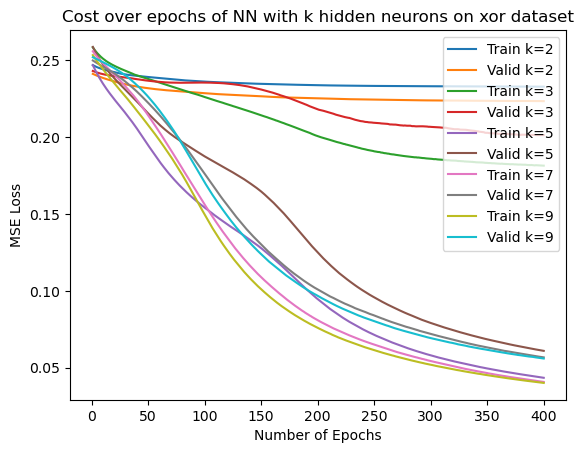

Test accuracy for xor dataset for NN with k=9 is 98.00%.


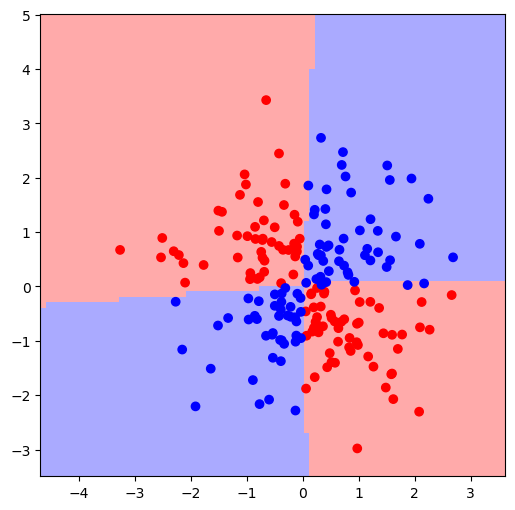


**************************************************
Beginning modelling for the center_surround dataset...

Training without regularization for k=2

Training without regularization for k=3

Training without regularization for k=5

Training without regularization for k=7

Training without regularization for k=9


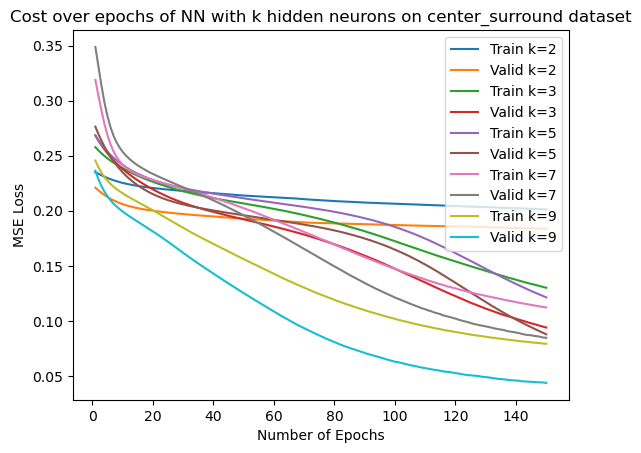

Test accuracy for center_surround dataset for NN with k=9 is 76.50%.


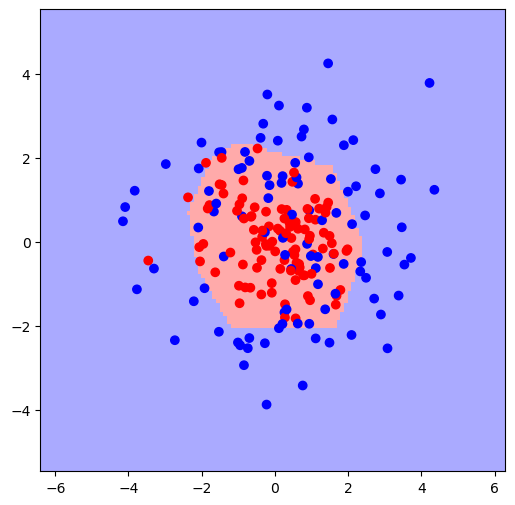


**************************************************
Beginning modelling for the two_gaussians dataset...

Training without regularization for k=2

Training without regularization for k=3

Training without regularization for k=5

Training without regularization for k=7

Training without regularization for k=9


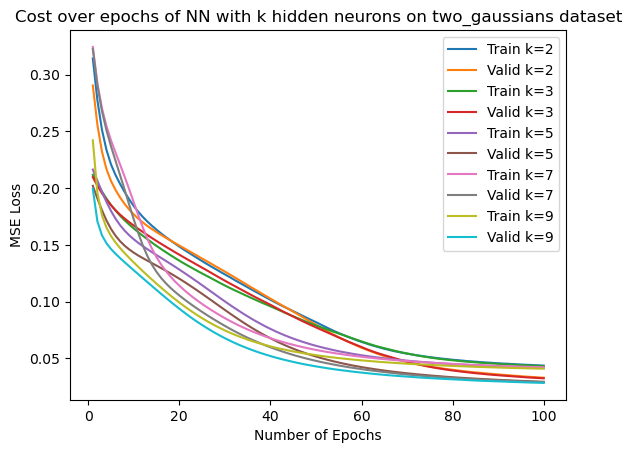

Test accuracy for two_gaussians dataset for NN with k=9 is 91.50%.


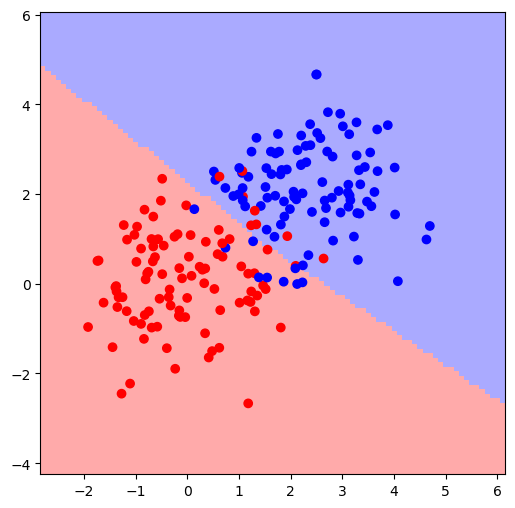


**************************************************
Beginning modelling for the spiral dataset...

Training without regularization for k=2

Training without regularization for k=3

Training without regularization for k=5

Training without regularization for k=7

Training without regularization for k=9


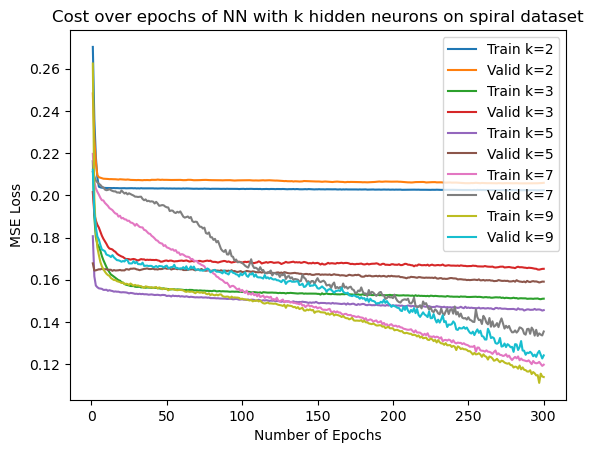

Test accuracy for spiral dataset for NN with k=9 is 82.50%.


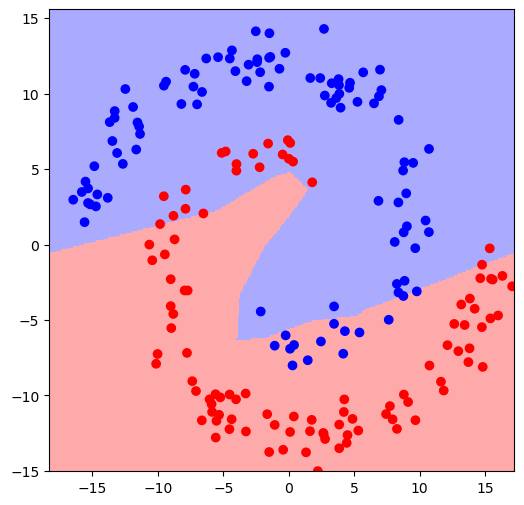


**************************************************


In [30]:
class Q2_Net(nn.Module):
    def __init__(self,k):
        #initialize parent class nn.Module 
        super(Q2_Net, self).__init__()
        #first linear layer with 3 input features, 'k' output neurons (no bias as it is appended separately)
        self.layer1 = nn.Linear(3, k, bias=False) # bias is appended to all samples from read_data function
        #second linear layer with 'k' input nerons, 2 output nerons (no bias as it is appended separately)
        self.layer2 = nn.Linear(k, 1, bias=False)

    def forward(self, input_vals):
        #convert input values to torch tensor if not already
        input_vals = torch.Tensor(input_vals)
        activation_1 = F.relu(self.layer1(input_vals)) 
        activation_2 = F.sigmoid(self.layer2(activation_1))
        return activation_2
    

class CustomDatasetQ2(CustomDatasetQ1):
    def __init__(self, data, labels):
        super().__init__(data, labels)
        self.data = data
        self.labels = labels


def acc_fn_q2(preds: torch.Tensor, labels: torch.Tensor) -> float:
    preds_rounded = preds.round()
    acc = preds_rounded.squeeze(-1) == labels.squeeze(-1)
    return acc.float().mean().item()


datasets = {
    'xor': {'batch_size': 5, 'learning_rate':0.01, 'num_epochs':400}, 
    'center_surround': {'batch_size': 5, 'learning_rate':0.01, 'num_epochs':150},
    'two_gaussians': {'batch_size': 5, 'learning_rate':0.01, 'num_epochs':100},
    'spiral': {'batch_size': 5, 'learning_rate':0.01, 'num_epochs':300}
}

#loop through datasets and train, validate, and test model for each configuration
for dataset, hyperparams in datasets.items():
    test_accuracy = train_valid_test_network(
        dataset=dataset, 
        dataset_cls=CustomDatasetQ2,
        accuracy_metric=acc_fn_q2,
        network=Q2_Net,
        batch_size=hyperparams['batch_size'],
        learning_rate=hyperparams['learning_rate'],
        num_epochs=hyperparams['num_epochs'],
        loss_fn=nn.MSELoss(),
        argmax_predictions=False,
        loss_fn_name='MSE Loss',
        use_regularization=False
    )
    print('\n', '*' * 50, sep='')

## Question 3. Manual Gradients and Updates (3.0 points)
Repeat either Step 1 or Step 2 *without* using a deep learning platform. You can use symbolic differentiation tools like WolramAlpha, Mathematica, etc., to compute gradients. You can also calculate the gradients by hand. You may want to calculate, code and verify gradients for individual components of your model and use the chain rule to build the gradients for specific weights and biases. You may also want to consider using for loops instead of matrix algebra in some parts of your code to avoid the ambiguity of broadcasting. You
may find it helpful to “calibrate” intermediate quantities in your implementation against your PyTorch implementation from Steps 1 or 2.


--- Dataset: xor ---


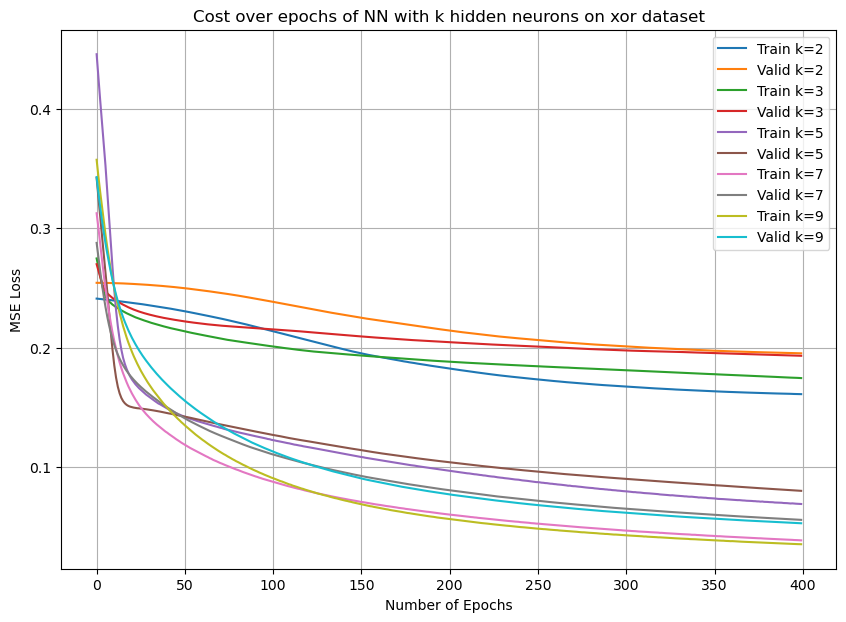

Best accuracy for xor dataset with k=9: 96.50%


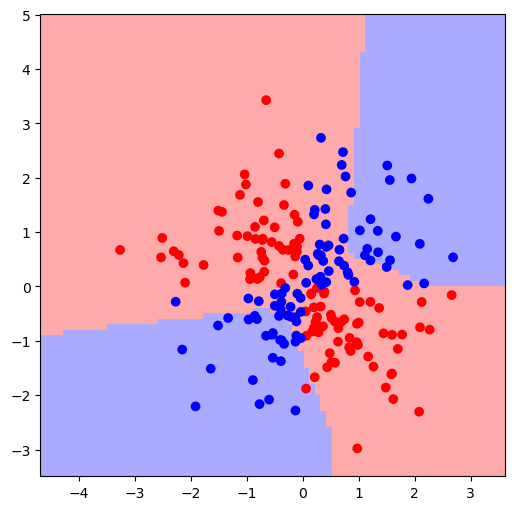


**************************************************

--- Dataset: center_surround ---


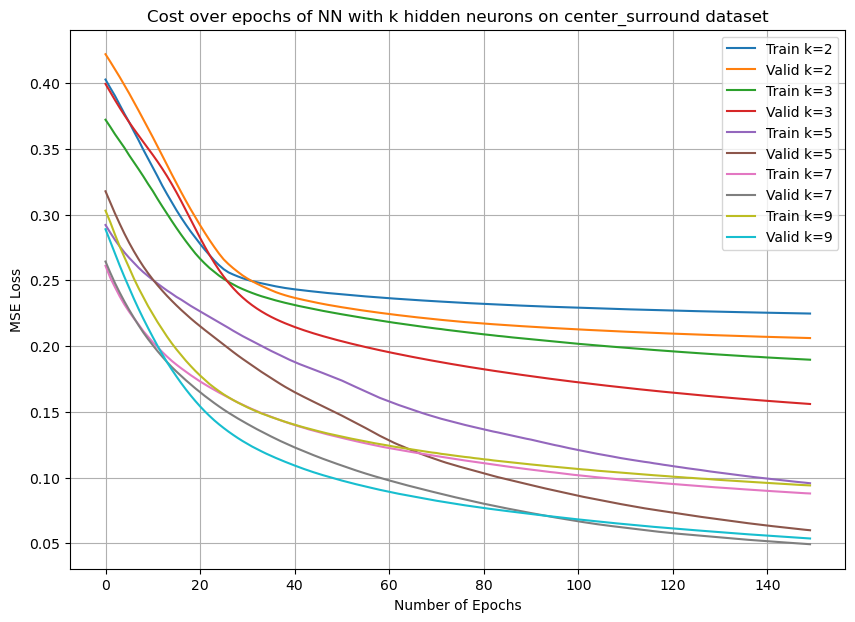

Best accuracy for center_surround dataset with k=7: 96.50%


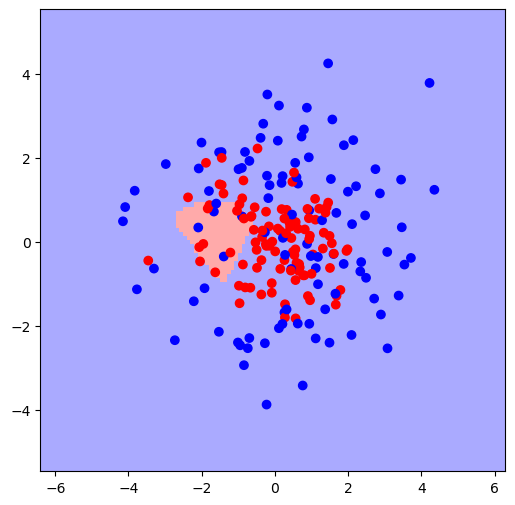


**************************************************

--- Dataset: two_gaussians ---


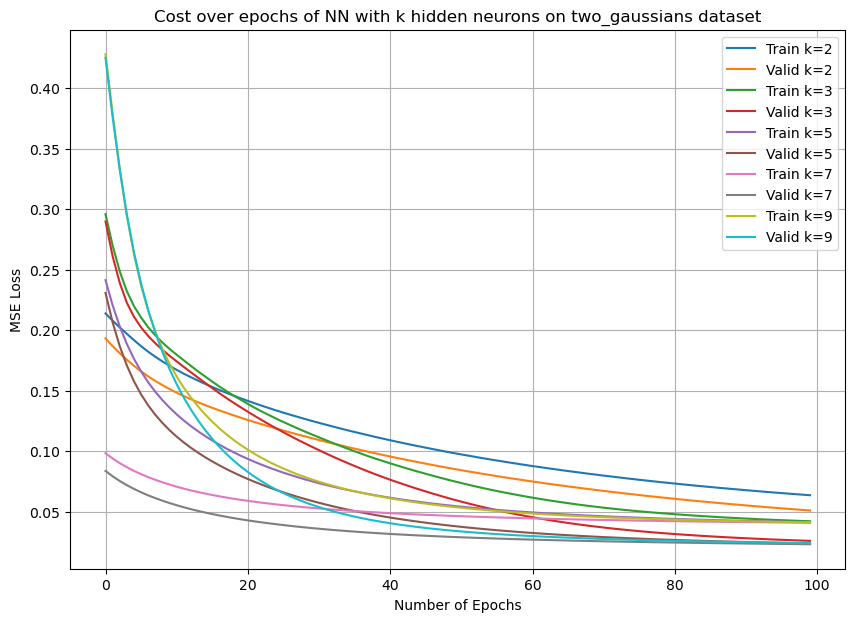

Best accuracy for two_gaussians dataset with k=9: 98.50%


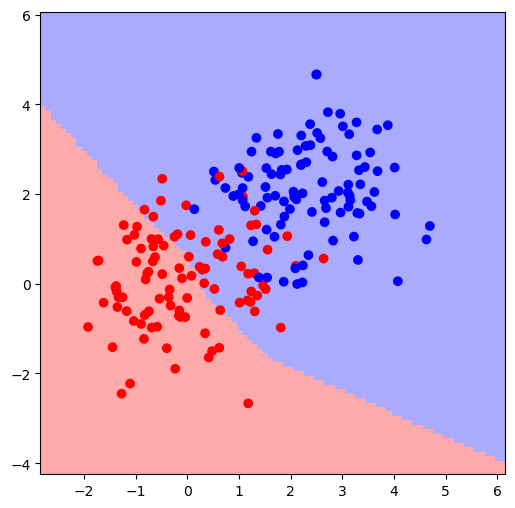


**************************************************

--- Dataset: spiral ---


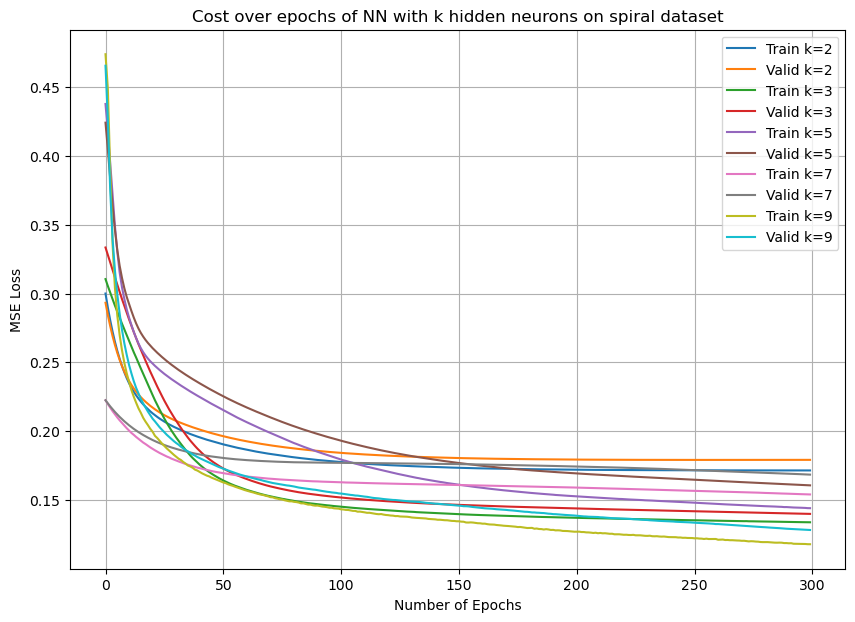

Best accuracy for spiral dataset with k=3: 80.50%


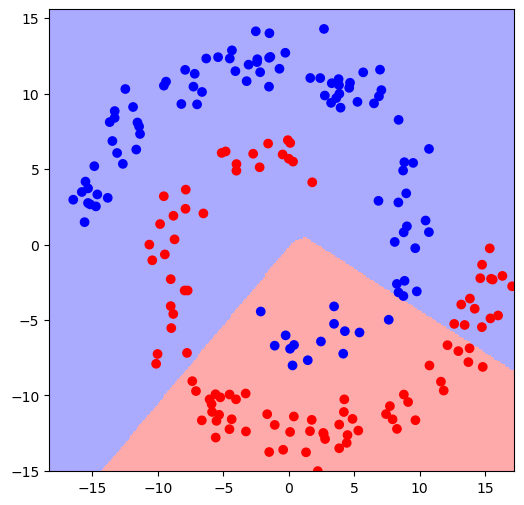


**************************************************


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

#set random seed for reproducibility of results
np.random.seed(343)

#activation functions
def relu(z):
    '''ReLU activation function: returns the maximum of 0 and the input.'''
    return np.maximum(0, z)

def relu_derivative(z):
    '''Derivative of the ReLU function: 1 for positive values of z, 0 otherwise.'''
    return (z > 0).astype(float)

def sigmoid(z):
    '''Sigmoid activation function: returns values in the range (0,1) for input z.'''
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    '''Derivative of the sigmoid function, used for backpropagation.'''
    s = sigmoid(z)
    return s * (1 - s)


#forward and backward pass functions for a 2-layer neural network
def forward(X, W1, b1, W2, b2):
    '''
    Performs forward pass through the network and returns intermediate values.
    
    Parameters:
        X: Input features.
        W1, b1: Weights and biases of the first (hidden) layer.
        W2, b2: Weights and biases of the second (output) layer.
    Returns:
        z1, a1: Linear and activated outputs of the hidden layer.
        z2, a2: Linear and activated outputs of the output layer.
    '''
    #linear output of hidden layer
    z1 = np.dot(X, W1) + b1  
    #activation output of hidden layer
    a1 = relu(z1)            
    #linear output of output layer
    z2 = np.dot(a1, W2) + b2 
    #activation output (final output prediction) 
    a2 = sigmoid(z2)          

    return z1, a1, z2, a2


def backward(X, y, z1, a1, a2, W1, b1, W2, b2, learning_rate):
    '''
    Performs backpropagation and updates weights and biases.
    
    Parameters:
        X, y: Input data and true labels.
        z1, a1: Linear and activation outputs of hidden layer.
        a2: Final output predictions.
        W1, b1, W2, b2: Weights and biases.
        learning_rate: Rate at which the model learns during training.
    Returns:
        Updated W1, b1, W2, b2 after applying gradients.
    '''

    #calculate error in output layer as the difference between predictions (a2) and true values (y),
    #   scaled by the derivative of the sigmoid to adjust based on activation sensitivity
    output_error = (a2 - y) * sigmoid_derivative(a2)
    #compute gradient for weights b/w hidden and output layres by averaging the dot product of 
    #   hidden layer activations (a1) and output error across the batch
    dW2 = np.dot(a1.T, output_error) / X.shape[0]
    #computer gradient for biases in the output layer by averaging the summed output errors
    db2 = np.sum(output_error, axis=0, keepdims=True) / X.shape[0]

    #backpropagate the output error to the hidden layer, scaling by the derivative of the ReLU function
    #   to reflect sensitivity in the hidden layer’s activations
    hidden_error = np.dot(output_error, W2.T) * relu_derivative(z1)
    #compute gradient for weights between input and hidden layers by averaging the dot product of
    #   inputs (X) and hidden layer error across the batch
    dW1 = np.dot(X.T, hidden_error) / X.shape[0]
    #compute gradient for biases in the hidden layer by averaging the summed hidden errors
    db1 = np.sum(hidden_error, axis=0, keepdims=True) / X.shape[0]

    # Update weights and biases by moving in the direction of the negative gradient, scaled by the learning rate
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2

    #return updated weights and biases
    return W1, b1, W2, b2


def plot_decision_boundary(name, W1, b1, W2, b2, argmax_predictions):
    '''
    Plots decision boundaries for a two-layer neural network classifier.
    
    Parameters:
        name: Name of the dataset being used, which is required for loading specific training and test data.
        W1, b1: Weights and biases for the hidden layer.
        W2, b2: Weights and biases for the output layer.
        argmax_predictions: Boolean that indicates if predictions are based on the maximum output value.
    
    This function:
    - Loads the specified training and testing data using the dataset name.
    - Creates a 2D grid to represent all possible feature values within the range of the training data.
    - For each point on the grid, calculates the neural network's prediction, assigning a class label based on
      the final output of the network.
    - Plots the decision boundary by color-coding regions according to class labels.
    - Overlays the test data points to visually assess the model's classification performance.
    
    This visualization aids in understanding how the model differentiates between classes across the feature space.
    '''

    #load training and testing data using the dataset name
    x_train, y_train, label_train = read_data(name, 'train')
    x_test, y_test, label_test = read_data(name, 'test')

    #set up a square plot area with one subplot, sized to 6x6 inches
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

    #define the resolution of ht emesh grid for decision boundary plotting
    h = .1 

    #set color maps: light colors for the background and bold colors for data points
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    #define the min and max range for grid, based on training data, with a margin of 1 unit
    x_min, x_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
    y_min, y_max = x_train[:, 2].min() - 1, x_train[:, 2].max() + 1

    #generate a mesh grid based on the feature ranges to cover the decision boundary area
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    #initialize a grid to store predictions for each point in the mesh grid
    Z = np.zeros([xx.shape[0], yy.shape[1]], dtype='float32')

    #prepare an input array to use for each point in the mesh grid
    grid_data2 = np.zeros([1, 3], dtype='float32')

    #iterate through each point in the mesh grid to determine its class based on network predictions
    for i in range(xx.shape[0]):
        for j in range(yy.shape[1]):
            #assign the current grid coordinates to x and y
            x = xx[i, j]
            y = yy[i, j]
            #set up the input data with bias term and the current x, y coordinates
            #bias term
            grid_data2[0, 0] = 1.0 
            grid_data2[0, 1] = x
            grid_data2[0, 2] = y

            #perform forward pass through the network to get prediction
            z1 = np.dot(grid_data2, W1) + b1
            a1 = relu(z1)
            z2 = np.dot(a1, W2) + b2
            a2 = sigmoid(z2)

            #assign a class label based on the output: 1 if output > 0.5, else 0
            yh = 1.0 if a2 > 0.5 else 0.0
            #store the prediction for visualization
            Z[i, j] = yh

    #display the decision boundary by coloring each region based on predicted class
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')
    #plot test data points over the decision boundary, colored by true class labels
    ax.scatter(x_test[:, 1], x_test[:, 2], c=y_test[:, 0], cmap=cmap_bold)
    #show the plot with decision boundary and test points
    plt.show()


# Define datasets with configurations, including learning rate and epochs
datasets = {
    'xor': {'data': map(np.array, read_data('xor', 'train')), 'learning_rate': 0.01, 'num_epochs': 400},
    'center_surround': {'data': map(np.array, read_data('center_surround', 'train')), 'learning_rate': 0.01, 'num_epochs': 150},
    'two_gaussians': {'data': map(np.array, read_data('two_gaussians', 'train')), 'learning_rate': 0.01, 'num_epochs': 100},
    'spiral': {'data': map(np.array, read_data('spiral', 'train')), 'learning_rate': 0.01, 'num_epochs': 300}
}

#set hidden layer sizes to experiment with different neural network architectures
#   each value represents the number of neurons in the hidden layer for a specific model configuration
hidden_sizes = [2, 3, 5, 7, 9]
#define the batch size for mini-batch gradient dsecent
batch_size = 5

#iterate over each dataset configuration for training and evaluation
for name, config in datasets.items():
    #load training, validation, and test data, and convert to numpy arrays for consistency
    X_train, y_train, _ = map(np.array, read_data(name, 'train'))
    X_valid, y_valid, _ = map(np.array, read_data(name, 'valid'))
    X_test, y_test, _ = map(np.array, read_data(name, 'test'))

    #standardize features across training, validation, and test sets for better convergence
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    X_test = scaler.transform(X_test)

    #reshape labels to 2D column vectors for compatibility with neural network outputs 
    y_train, y_valid, y_test = y_train.reshape(-1, 1), y_valid.reshape(-1, 1), y_test.reshape(-1, 1)
    #retrieve dataset-specific learning rate
    learning_rate = config['learning_rate']
    #retrieve dataset-specific number of training epochs
    num_epochs = config['num_epochs']
    
    #indicate the start of training for the current dataset
    print(f"\n--- Dataset: {name} ---")
    
    #track the best model configuration based on highest validation accuracy achieved 
    best_accuracy = 0
    #initialize placeholders for best weights/biases
    best_W1, best_b1, best_W2, best_b2 = None, None, None, None
    #placeholder for best hidden layer size
    best_k = None

    #initialize plot for tracking training and validation losses over different hidden layer sizes
    plt.figure(figsize=(10, 7))
    for hidden_size in hidden_sizes:
        #randomly initialize weights and biases for the hidden and output layers
        W1 = np.random.randn(X_train.shape[1], hidden_size)
        b1 = np.zeros((1, hidden_size))
        W2 = np.random.randn(hidden_size, 1)
        b2 = np.zeros((1, 1))

        #track loss for each epoch to plot later
        train_losses, valid_losses = [], []

        #training loop over the specified number of epochs
        for epoch in range(num_epochs):
            #shuffle training data at each epoch to improve generalization and reduce overfitting
            perm = np.random.permutation(X_train.shape[0])
            X_train_shuffled = X_train[perm]
            y_train_shuffled = y_train[perm]
            
            #accumulate batch loss across mini-batches for current epoch
            batch_train_loss = 0

            #mini-batch gradient descent loop
            for i in range(0, X_train.shape[0], batch_size):
                #prepare current mini-batch of training data
                X_batch = X_train_shuffled[i:i+batch_size]
                y_batch = y_train_shuffled[i:i+batch_size]
                
                #perform forward pass and backpropagation, then update weights and biases
                z1, a1, z2, a2 = forward(X_batch, W1, b1, W2, b2)
                W1, b1, W2, b2 = backward(X_batch, y_batch, z1, a1, a2, W1, b1, W2, b2, learning_rate)
                
                #calculate mean squared error for current batch and accumulate it
                batch_loss = np.mean((a2 - y_batch) ** 2)
                #scale batch loss by batch size
                batch_train_loss += batch_loss * X_batch.shape[0]

            #calculate average training loss for the entire epoch
            train_loss = batch_train_loss / X_train.shape[0]
            train_losses.append(train_loss)

            #compute and track validation loss to monitor generalization performance
            _, _, _, a2_valid = forward(X_valid, W1, b1, W2, b2)
            valid_loss = np.mean((a2_valid - y_valid) ** 2)
            valid_losses.append(valid_loss)

        #plot training and validation losses for current hidden layer size
        plt.plot(train_losses, label=f"Train k={hidden_size}")
        plt.plot(valid_losses, label=f"Valid k={hidden_size}")

        #compute validation accuracy and update best model configuration if accuracy improves
        predictions = (a2_valid > 0.5).astype(int)
        #calculate accuracy as a percentage
        accuracy = (predictions == y_valid).mean() * 100
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_W1, best_b1, best_W2, best_b2 = W1.copy(), b1.copy(), W2.copy(), b2.copy()
            #track the hidden layer size for the best model
            best_k = hidden_size


    #configure and display the plot for loss over epochs for different hidden layer sizes
    plt.title(f"Cost over epochs of NN with k hidden neurons on {name} dataset")
    plt.xlabel("Number of Epochs")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    #print the best accuracy achieved for the current dataset
    print(f"Best accuracy for {name} dataset with k={best_k}: {best_accuracy:.2f}%")

    #use the best weights and biases to visualize decision boundaries on test data
    plot_decision_boundary(name=name, W1=best_W1, b1=best_b1, W2=best_W2, b2=best_b2, argmax_predictions=True)
    #divider for readability in console output
    print('\n', '*' * 50, sep='')


## Question 4. Regularizers (3.0 points)

Repeat either Step 1 or 2 above, adding two regularizers to your PyTorch implementation. The first regularizer should minimize the norm of the input layer weight matrix. The second regularizer should encourage orthogonality in the intermediate decision boundaries learned in the first layer (note: we discussed this in class as interpreting the output of each hidden node as a single layer perceptron where the weight matrix feeding into a hidden node
can be thought of as the $g(x)$ in the perceptron). In addition to items a through e listed under step one, plot the intermediate decision boundaries of the regularized and unregularized FFNN (see example below). You may find it helpful to work with either the xor data with $k = 3$ for MSE, or the spiral dataset with $k = 3$ for MCE.

Beginning modelling for the xor dataset...

Training with regularization


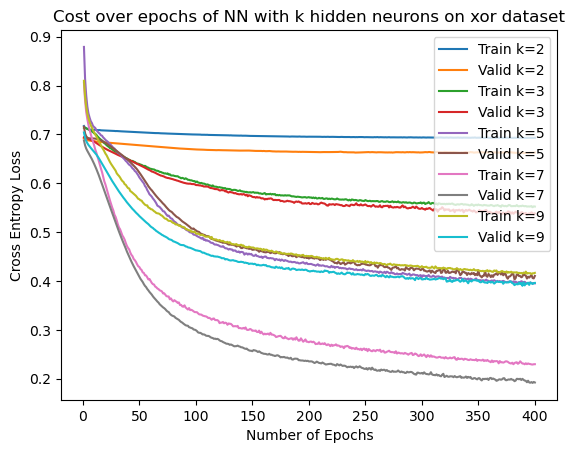

Test accuracy for xor dataset for NN with k=9 is 97.50%.


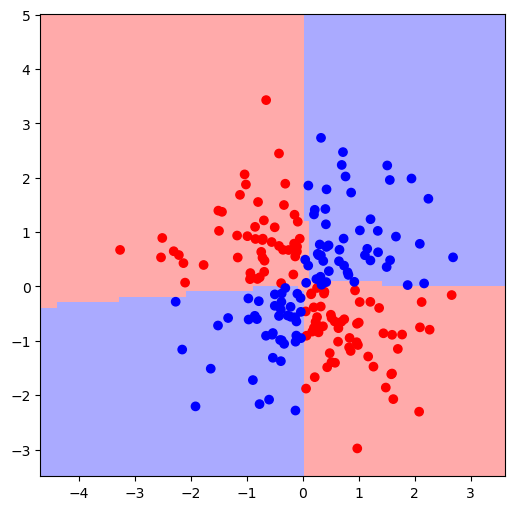

TypeError: tuple indices must be integers or slices, not tuple

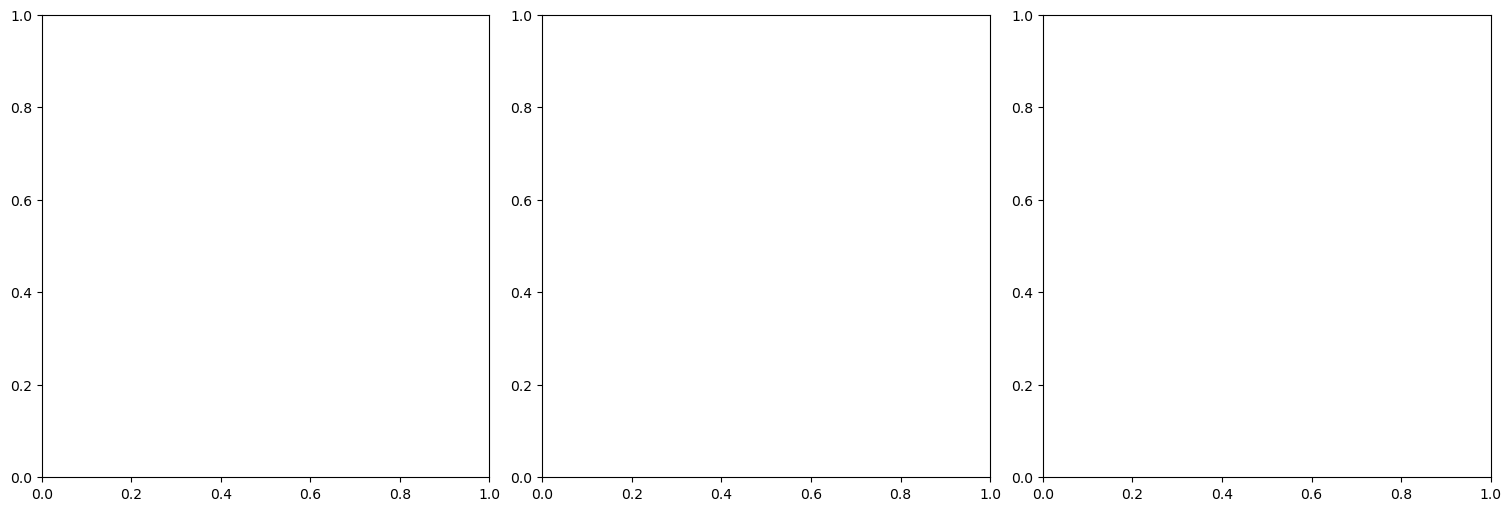

In [48]:
class Q4_Net(nn.Module):
    def __init__(self, k):
        #initialize parent class nn.Module 
        super(Q4_Net, self).__init__()
        #first linear layer with 3 input features, 'k' output neurons (no bias as it is appended separately)
        self.layer1 = nn.Linear(3, k, bias=False) # bias is appended to all samples from read_data function
        #second linear layer with 'k' input nerons, 2 output nerons (no bias as it is appended separately)
        self.layer2 = nn.Linear(k, 2, bias=False)

    def forward(self, input_vals):
        #convert input values to torch tensor if not already
        input_vals = torch.Tensor(input_vals)
        activation_1 = F.relu(self.layer1(input_vals)) 
        logits = self.layer2(activation_1)
        # if self.training:
        #     return logits, activation_1
        # else:
        #     return logits

        # print(f"Intermediate Activations for Hidden Layer (k={self.layer1.out_features}):\n{activation_1.detach().numpy()}")
        return logits, activation_1

    #L2 is helping reduce the importance given to features by penalizing the larger weights
    def l2_regularizer(self):
        # L2 norm of the weights of the input layer
        return torch.norm(self.layer1.weight, p=2) #p specifies the argument L2
    
    #Orthoganal regularizer helps in finding the difference in the features being learned
    #If the weight matrix is not similar to an identity matrix, it is penalized
    def ortho_regularizer(self, layer2_inputs):
        # Compute the Gram matrix of the activations 
        # Gram matrix is W_T.W which gives us the approximations of how close it is to Identity matrix
        G = torch.matmul(layer2_inputs.T, layer2_inputs)
        identity = torch.eye(G.size(0))

        # The regularization term: penalize deviation from orthogonality
        return torch.norm(G - identity)

def plot_intermediate_boundaries(model, dataset_name, k, use_regularizer = False):


    # Load the dataset for visualization
    x_train, y_train, _ = read_data(dataset_name, 'train')
    x_min, x_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
    y_min, y_max = x_train[:, 2].min() - 1, x_train[:, 2].max() + 1

    # Create a mesh grid
    h = 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid = np.c_[np.ones_like(xx.ravel()), xx.ravel(), yy.ravel()]  # Add bias term

    with torch.no_grad():
        # Pass the grid through the model
        if use_regularizer == True:
            grid_tensor = torch.from_numpy(grid).float()
            _, activations = model(grid_tensor)
        else:
            grid_tensor = torch.from_numpy(grid).float()
            activations = model(grid_tensor)


     # Define custom colors
        cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])  # Light red and blue
        cmap_bold = ListedColormap(['#FF0000', '#0000FF'])   # Bold red and blue

        # Plot decision regions for each hidden neuron
        fig, axes = plt.subplots(1, k, figsize=(15, 5), constrained_layout=True)
        for node in range(k):
            ax = axes[node]
            
            # Get activation values for the neuron
            activations_node = activations[:, node].numpy().reshape(xx.shape)

            # Plot decision regions
            ax.pcolormesh(xx, yy, activations_node > 0.5, cmap=cmap_light, alpha=0.6)
            ax.scatter(x_train[:, 1], x_train[:, 2], c=y_train[:, 0], cmap=cmap_bold)
            
            # Add titles and labels
            ax.set_title(f"Neuron {node + 1} (k={k})")
            ax.set_xlabel("Feature 1")
            ax.set_ylabel("Feature 2")

        plt.suptitle(f"Neuron Decision Regions for Hidden Layer (k={k}) on {dataset_name}")
        plt.show()
        #  # Display the loss plot
        # plt.title(f'Cost over epochs of NN with k hidden neurons on {dataset} dataset')
        # plt.xlabel('Number of Epochs')
        # plt.ylabel(loss_fn_name)
        # plt.legend(loc='upper right')
        # plt.show()


class CustomDatasetQ4(CustomDatasetQ1):
    def __init__(self, data, labels):
        super().__init__(data=data, labels=labels)


datasets = {
    'xor': {'batch_size': 5, 'learning_rate':0.01, 'num_epochs':400}, 
    'center_surround': {'batch_size': 5, 'learning_rate':0.01, 'num_epochs':150},
    'two_gaussians': {'batch_size': 5, 'learning_rate':0.01, 'num_epochs':100},
    'spiral': {'batch_size': 5, 'learning_rate':0.01, 'num_epochs':300}
}

#loop through datasets and train, validate, and test model for each configuration
acc_fn_q4 = acc_fn_q1

for dataset, hyperparams in datasets.items():
    model = Q4_Net(k=3)  # Set k=3
    _ = train_valid_test_network(
        dataset=dataset,
        dataset_cls=CustomDatasetQ4,
        accuracy_metric=acc_fn_q4,
        network=Q4_Net,
        batch_size=hyperparams['batch_size'],
        learning_rate=hyperparams['learning_rate'],
        num_epochs=hyperparams['num_epochs'],
        loss_fn=nn.CrossEntropyLoss(),
        loss_fn_name='Cross Entropy Loss',
        argmax_predictions=True,
        use_regularization=True,
        plot_epochs=[50, 100, 200, 400]
    )
    # Plot intermediate decision boundaries
    plot_intermediate_boundaries(model, dataset, k=3, use_regularizer=True)

    print('\n', '*'*100, sep='')
#loop through datasets and train, validate, and test model for each configuration
for dataset, hyperparams in datasets.items():
    model = Q4_Net(k=3)  # Set k=3
    test_accuracy = train_valid_test_network(
        dataset=dataset, 
        dataset_cls=CustomDatasetQ4,
        accuracy_metric=acc_fn_q4,
        network=Q4_Net,
        batch_size=hyperparams['batch_size'],
        learning_rate=hyperparams['learning_rate'],
        num_epochs=hyperparams['num_epochs'],
        loss_fn=nn.CrossEntropyLoss(),
        loss_fn_name='Cross Entropy Loss',
        use_regularization=False,
    )
    print('\n', '*'*100, sep='')


# Plot intermediate decision boundaries
    plot_intermediate_boundaries(model, dataset, k=3, use_regularizer=False)